In [34]:
import os
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
from pydub.utils import make_chunks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
from datetime import datetime
from label_studio_sdk import Client

In [35]:
# Connect Label Studio
label_studio_url = "http://localhost:8080"
api_key = "23ce5b08cc51665ab3bb19e0bf0c43b21c7c0723"
client = Client(url=label_studio_url, api_key=api_key)

In [36]:
# Step 2: Get project from Label Studio
project_id = 8
project = client.get_project(project_id)

In [37]:
# Step 3: Fetch annotations and prepare data
annotations = project.get_tasks()
audio_path_root = "/home/oskhar/.local/share/label-studio/media/"

In [38]:
def extract_mfcc(audio_path, start, end, sample_rate=16000, n_mfcc=40, max_len=128):
    """
    Ekstraksi MFCC dari segmen audio dengan padding atau cropping.
    """
    try:
        # Load audio menggunakan pydub
        audio = AudioSegment.from_file(audio_path)
        # Potong segmen berdasarkan waktu (dalam milidetik)
        segment = audio[start * 1000:end * 1000]
        # Konversi audio ke numpy array
        samples = np.array(segment.get_array_of_samples(), dtype=np.float32)
        # Resample audio jika diperlukan
        samples_resampled = librosa.resample(samples, orig_sr=segment.frame_rate, target_sr=sample_rate)
        # Ekstraksi MFCC
        mfcc_features = librosa.feature.mfcc(y=samples_resampled, sr=sample_rate, n_mfcc=n_mfcc)
        # Pad atau crop MFCC agar memiliki dimensi tetap
        if mfcc_features.shape[1] < max_len:
            pad_width = max_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc_features = mfcc_features[:, :max_len]
        return mfcc_features
    except Exception as e:
        print(f"Error processing {audio_path} from {start} to {end}: {e}")
        return None

In [39]:
# Proses dataset
audio_files = []
labels = []
label_mapping = {}  # Mapping label ke integer
label_counter = 0

In [40]:
for row in annotations:
    audio_path_tmp = row['data']['audio']  # Path to audio file
    audio_path = audio_path_root + audio_path_tmp.replace("/data/", "")
    label_data_tmp = row["data"]["label"]
    label_data = eval(label_data_tmp)  # Anotasi dalam bentuk list of dictionaries

    for annotation in label_data:
        print("proses data")
        start = annotation["start"]
        end = annotation["end"]
        label_name = annotation["labels"][0]  # Nama label pertama

        # Mapping label ke integer jika belum ada
        if label_name not in label_mapping:
            label_mapping[label_name] = label_counter
            label_counter += 1

        # Ekstraksi MFCC menggunakan pydub
        mfcc = extract_mfcc(audio_path, start, end)

        # Validasi apakah file mfcc berhasil diload
        if mfcc is not None and mfcc.shape == (40, 128):  # Validasi dimensi MFCC
            audio_files.append(mfcc)
            labels.append(label_mapping[label_name])
        else:
            print("not loaded mfcc")

proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
proses data
pros

In [41]:
# Konversi dataset menjadi numpy arrays
X_data = np.stack(audio_files)  # Gunakan np.stack untuk memastikan array memiliki dimensi seragam
y_labels = to_categorical(labels, num_classes=len(label_mapping))

In [42]:
# Split data menjadi training (70%), validation (15%), dan testing (15%)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_data, y_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [43]:
# Reshape data agar sesuai dengan input CNN
X_train = X_train[..., np.newaxis]  # Tambahkan channel untuk grayscale
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [45]:
# Definisi model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularisasi
    Dense(len(label_mapping), activation='softmax')  # Output sesuai jumlah kelas
])

In [46]:
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Pelatihan model dengan pelacakan waktu
start_time = datetime.now()
print(f"Training started at: {start_time}")

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32
)

end_time = datetime.now()
print(f"Training ended at: {end_time}")
print(f"Training duration: {end_time - start_time}")

Training started at: 2025-01-27 18:48:07.620393
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7569 - loss: 2.4243 - val_accuracy: 0.9221 - val_loss: 0.2578
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8972 - loss: 0.2862 - val_accuracy: 0.9437 - val_loss: 0.1645
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9248 - loss: 0.2141 - val_accuracy: 0.9610 - val_loss: 0.1327
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9469 - loss: 0.1323 - val_accuracy: 0.9610 - val_loss: 0.1372
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9589 - loss: 0.1145 - val_accuracy: 0.9654 - val_loss: 0.1226
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9722 - loss: 0.0927 - val_accuracy: 0.9740 - val_loss: 0.1089
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9644 - loss: 0.1067 - val_accuracy: 0.9740 - val_loss: 0.0893
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 

In [48]:
# Evaluasi model pada data testing
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 - 0s - 13ms/step - accuracy: 0.9697 - loss: 0.1274
Test Loss: 0.12740159034729004
Test Accuracy: 0.9696969985961914


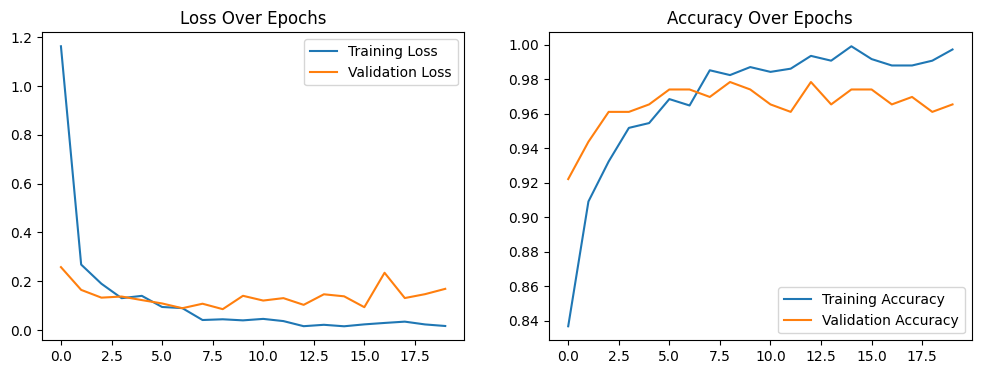

In [49]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [51]:

# Simpan model
model.save("cnn_audio_recognition.keras")